This Notebook shows how to optimise the pruning parameters of your network based on pairwise connectivity data.

First we need to create a small network that we can use for the optimisation of the pruning parameters.

In this example we do not need to have realistic neuron densities, so we will place the neurons in a cube of diameter 100 micrometers.

In [1]:
import os
network_path = os.path.join("networks","dspn_to_dspn")
n_neurons = 100
pop_size = 10
epochs = 10

pre_type = "dSPN"
post_type = "dSPN"
con_type = "GABA"

SPN2SPNdistDepPruning = "1-exp(-(0.4*d/60e-6)**2)"
extra_pruning_parameters = { 'distPruning': SPN2SPNdistDepPruning }

experimental_data = [(0, 50e-6, 3/47.0), (0, 100e-6, 3/66.0)]
avg_num_synapses_per_pair = [3, 0.05]  # Expected mean, error weight

In [2]:
from snudda.place.create_cube_mesh import create_cube_mesh

mesh_file = os.path.join(network_path, "cube-mesh.obj")
create_cube_mesh(mesh_file, [0,0,0], 100e-6)

from snudda.init import SnuddaInit
si = SnuddaInit(network_path=network_path, random_seed=123, snudda_data="../../../../BasalGangliaData/data/")

si.define_structure(struct_name="Cube", struct_mesh=mesh_file, d_min=12e-6, mesh_bin_width=25e-6)

if pre_type == post_type:
    si.add_neurons(name=pre_type, num_neurons=n_neurons, volume_id="Cube",
                    neuron_dir=os.path.join("$DATA","neurons","striatum","dspn"))
else:
    si.add_neurons(name=pre_type, num_neurons=int(n_neurons/2), volume_id="Cube",
                    neuron_dir=os.path.join("$DATA","neurons","striatum","dspn"))
    si.add_neurons(name=post_type, num_neurons=int(n_neurons/2), volume_id="Cube",
                    neuron_dir=os.path.join("$DATA","neurons","striatum","dspn"))
    

# The parameters here does not matter, they will be set during optimisation
si.add_neuron_target(neuron_name=pre_type,
                     target_name=post_type,
                     connection_type=con_type,
                     dist_pruning=SPN2SPNdistDepPruning,
                     f1=None, soft_max=None, mu2=None,
                     a3=None,
                     conductance=[0.24e-9, 0.1e-9],
                     mod_file="tmGabaA")

si.write_json()

Adding neurons: dSPN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/dspn
Writing networks/dspn_to_dspn/network-config.json


In [3]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/dspn_to_dspn/network-config.json


Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/dspn_to_dspn/network-config.json


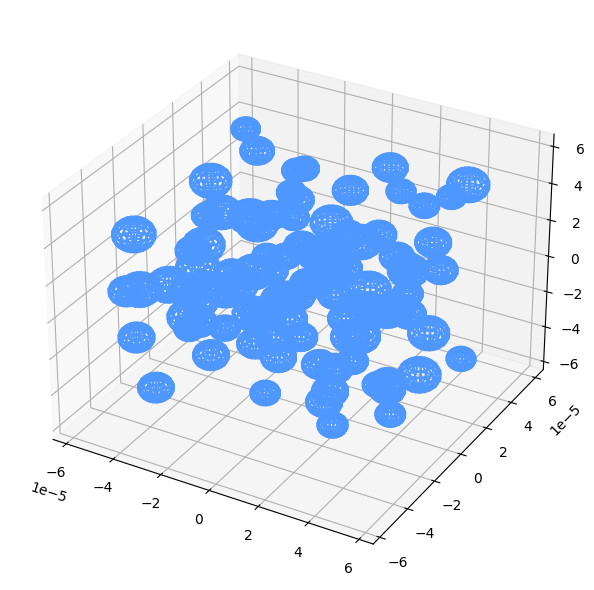

In [4]:
from snudda.plotting import PlotNetwork
network_file = os.path.join(network_path, "network-neuron-positions.hdf5")
pn = PlotNetwork(network_file)
pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False)
pn.close() 

In [5]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, hyper_voxel_size=100)
sd.detect()

Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/dspn_to_dspn/network-config.json
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 56/125 (100 neurons)
Processing hyper voxel : 31/125 (100 neurons)
Processing hyper voxel : 30/125 (85 neurons)
Processing hyper voxel : 32/125 (84 neurons)
Processing hyper voxel : 36/125 (83 neurons)
Processing hyper voxel : 26/125 (78 neurons)
Processing hyper voxel : 61/125 (71 neurons)
Processing hyper voxel : 51/125 (65 neurons)
Processing hyper voxel : 55/125 (61 neurons)
Processing hyper voxel : 57/125 (58 neurons)
Processing hyper voxel : 35/125 (37 neurons)
Processing hyper voxel : 6/125 (32 neurons)
Processing hyper voxel : 25/125 (31 neurons)
Processing hyper voxel : 27/125 (29 neurons)
Processing hyper voxel : 37/125 (29 neurons)
Processing hyper voxel : 52/125 (21 neurons)
Processing hyper voxel : 62/125 (20 neurons)
Processing hyper voxel : 50/125 (19 neurons)
Processing hyper voxel : 60/1

In [6]:
from snudda.optimise.optimise_pruning import OptimisePruning
op = OptimisePruning(network_path=network_path, pop_size=pop_size, epochs=epochs)

In [7]:
op.merge_putative_synapses()

Read 168329 out of total 168329 synapses


In [8]:
op.prune.connectivity_distributions

{(1,
  1,
  10): (OrderedDict([('f1', 1.0),
               ('softMax', None),
               ('mu2', None),
               ('a3', None),
               ('distPruning', '1-exp(-(0.4*d/60e-6)**2)'),
               ('cluster', False)]), None)}

In [9]:
op.prune.type_id_lookup

{'dSPN': 1}

In [10]:
op.prune.hist_file["meta/connectivityDistributions"][()]

b'{"dSPN$$dSPN": {"GABA": {"conductance": [2.4e-10, 1e-10], "channelParameters": {"modFile": "tmGabaA"}, "clusterSize": 1, "clusterSpread": null, "pruning": {"f1": null, "softMax": null, "mu2": null, "a3": null, "distPruning": "1-exp(-(0.4*d/60e-6)**2)", "cluster": false}, "channelModelID": 10, "lognormal_mu_sigma": [-22.230424900260093, 0.40010675493807013]}}}'

In [11]:
res = op.optimize(pre_type=pre_type, post_type=post_type, con_type=con_type, experimental_data=experimental_data, extra_pruning_parameters=extra_pruning_parameters)

/home/hjorth/HBP/Snudda/venv/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:377: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

In [ ]:
res

In [ ]:
import os
from snudda.analyse.analyse import SnuddaAnalyse

network_file = os.path.join(network_path, "network-synapses-e1758f28-37e3-4405-b3af-b3fd1f0a8c19.hdf5")
dist3D = False
y_max_H = None

sa = SnuddaAnalyse(network_file)

In [ ]:
sa.plot_connection_probability("dSPN", "dSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data=[5 / 19.0, 3 / 43.0],
                               exp_data_detailed=[(5, 19), (3, 43)])